# Bergland et al. (2014) Data Processing and Analysis

## Setup

In [17]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import re
import pickle
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [19]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

In [20]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [21]:
np.random.seed(0)

# Data and Annotation Loading

### Load in VCF

In [22]:
VCF_FILE = '../data/bergland_et_al_2014/6d_v7.3_output_fixed_filtered.vcf.gz'

sf = vf.AD_DP_VCFFile(VCF_FILE)
gi = sf.build_gintervals()

reading file '../data/bergland_et_al_2014/6d_v7.3_output_fixed_filtered.vcf.gz'...
file '../data/bergland_et_al_2014/6d_v7.3_output_fixed_filtered.vcf.gz' loaded.
total time to load VCF file: 0.20531326929728191 mins.


### Design

We focus on just the PA temporal samples. Our design is one replicate, six or seven timepoints (six if we ignore the out of season sample `PA_10_2011`).

In [23]:
[(i, s) for i, s in enumerate(sf.samples)]

[(0, 'FL1'),
 (1, 'FL2'),
 (2, 'GA'),
 (3, 'SC'),
 (4, 'NC'),
 (5, 'ME1'),
 (6, 'ME2'),
 (7, 'PA_7_2009'),
 (8, 'PA_11_2009'),
 (9, 'PA_7_2010'),
 (10, 'PA_11_2010'),
 (11, 'PA_7_2011'),
 (12, 'PA_10_2011'),
 (13, 'PA_11_2011')]

In [24]:
design_1_indices = [7, 8, 9, 10, 11, 12]
design_1_samples = [sf.samples[i] for i in design_1_indices]
design_1 = [('pa', i) for i, _ in enumerate(design_1_samples)]

In [25]:
design_1_samples

['PA_7_2009',
 'PA_11_2009',
 'PA_7_2010',
 'PA_11_2010',
 'PA_7_2011',
 'PA_10_2011']

In [26]:
timepoints = np.array([s.strip('PA_').replace('_', '/') for s in sf.samples if s.startswith('PA')])
timepoints
timedeltas = np.array([timepoints[i] + '-' + timepoints[i+1] for i in range(len(timepoints)-1)])

This is in the header of the VCF file:

In [27]:
diploids = np.array([39, 48, 51, 48, 46, 86, 75, 55, 74, 116, 33, 75, 47, 50])

In [28]:
tile_width = 1e5
gi.infer_seqlens()
tiles = GenomicIntervals.from_tiles(gi.seqlens, width=tile_width)

In [29]:
d = TiledTemporalFreqs(tiles, 
                       freqs=sf.freqs[:, design_1_indices].T, 
                       depths=sf.N[:, design_1_indices].T,
                       diploids=diploids[design_1_indices],
                       samples=design_1, gintervals=gi)

In [30]:
d.calc_cov(use_masked=True)

array([[ 0.01793126, -0.00641262,  0.00086914, -0.00038181,  0.0003435 ],
       [-0.00641262,  0.03110226, -0.01546535, -0.00617699,  0.00067976],
       [ 0.00086914, -0.01546535,  0.0167546 , -0.00257925, -0.00142411],
       [-0.00038181, -0.00617699, -0.00257925,  0.02088168, -0.00589106],
       [ 0.0003435 ,  0.00067976, -0.00142411, -0.00589106,  0.00875655]])

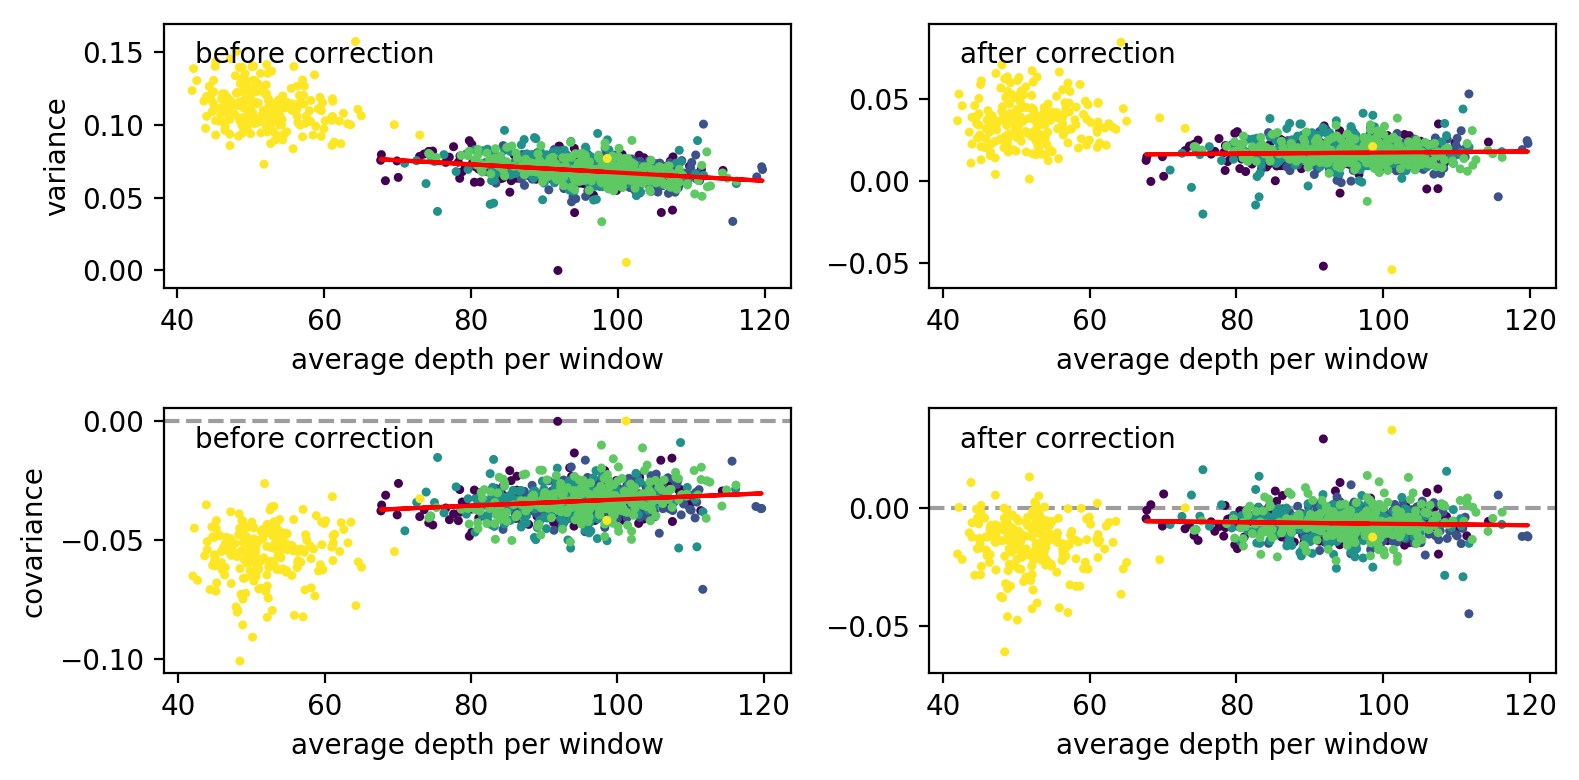

In [31]:
diagnostics = d.correction_diagnostics(exclude_seqids=['X'], use_masked=True, offdiag_k=1, depth_limits=(30, 120))
_ = correction_diagnostic_plot(diagnostics)

with open("../data/bergland_et_al_2014/bergland_diagonistics_tuple.pkl", 'wb') as f:
    pickle.dump(diagnostics, f)

In [32]:
megabase_tiles = GenomicIntervals.from_tiles(d.gintervals.seqlens, width=1e6)
d.set_tiles(megabase_tiles)
print("number of blocks: ", len(d.tile_indices))

number of blocks:  116


In [33]:
gw_temp_covs_cis = d.bootstrap_cov(B=5000, use_masked=True, progress_bar=True)

In [34]:
gw_temp_covs_cis

array([[[ 1.67587110e-02, -7.05167222e-03,  3.57696254e-04,
         -9.57849236e-04, -1.53427923e-04],
        [-7.05167222e-03,  2.95014725e-02, -1.66466131e-02,
         -6.86334125e-03,  8.42689861e-05],
        [ 3.57696254e-04, -1.66466131e-02,  1.56265788e-02,
         -3.60396751e-03, -1.93466745e-03],
        [-9.57849236e-04, -6.86334125e-03, -3.60396751e-03,
          1.89518776e-02, -6.64800380e-03],
        [-1.53427923e-04,  8.42689861e-05, -1.93466745e-03,
         -6.64800380e-03,  7.60995430e-03]],

       [[ 1.79312556e-02, -6.41261680e-03,  8.69144177e-04,
         -3.81814486e-04,  3.43501458e-04],
        [-6.41261680e-03,  3.11022622e-02, -1.54653469e-02,
         -6.17699284e-03,  6.79764888e-04],
        [ 8.69144177e-04, -1.54653469e-02,  1.67546045e-02,
         -2.57924849e-03, -1.42411254e-03],
        [-3.81814486e-04, -6.17699284e-03, -2.57924849e-03,
          2.08816829e-02, -5.89106283e-03],
        [ 3.43501458e-04,  6.79764888e-04, -1.42411254e-03,
  

In [35]:
with open(f'../data/bergland_et_al_2014/tile_temporal_covs_1e6.npy', 'wb') as f:
    np.save(f, gw_temp_covs_cis)

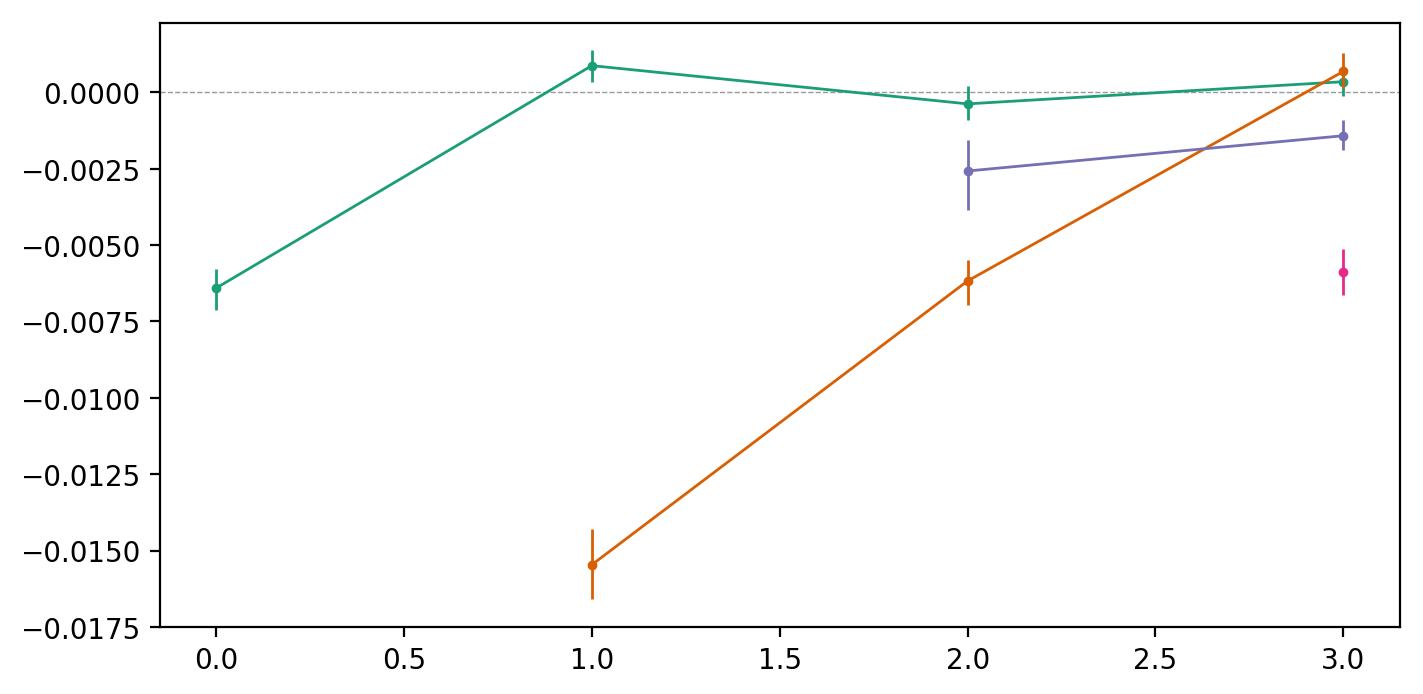

In [42]:
def cov_plot(cov_cis, ax=None, alpha=1, error_alpha=1, ngens=1, linewidth=1, ylim=None, xlim=None, hline=True, 
             cmap=cm.Dark2, y_multiplier=None, xticks=None, ylab=None):
    if ax is None:
        fig, ax = plt.subplots()
    _, T, T = cov_cis.shape
    y_multiplier = y_multiplier if y_multiplier is not None else 1
    for refgen in range(T):
        x = np.arange(refgen, T) 
        mean = y_multiplier*cov_cis[1][refgen, (refgen+1):]
        lower, upper = y_multiplier*cov_cis[0][refgen, (refgen+1):]-mean, mean-y_multiplier*cov_cis[2][refgen, (refgen+1):]
        
        #ax.plot(np.broadcast_to(ngens*np.arange(refgen, T), (2, T-refgen)), temp_covs_bs[(0, 2), refgen, refgen:])
        ax.plot(x[:-1], mean, '-o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
                label=refgen, zorder=refgen, markersize=2.5) #markersize=3.5)#, markeredgecolor='w')
        #ax.plot(x[:-1], mean, 'o', linewidth=linewidth, solid_capstyle='round', alpha=alpha, c=cmap(refgen), 
        #        label=refgen, zorder=refgen) #markersize=4.3)# markeredgecolor='w')
        ax.errorbar(x[:-1], mean, yerr=np.column_stack([lower.ravel(), upper.ravel()]).T, 
                    capsize=0, elinewidth=linewidth, c=cmap(refgen), 
                    linewidth=0,
                    zorder=100+refgen, alpha=error_alpha, label=None, solid_capstyle='round')

    if ylim is not None:
        plt.ylim(ylim)
    
    if xlim is not None:
        plt.xlim(xlim)
    #plt.xticks(np.arange(0, T*ngens, 10))
    if xticks is not None:
        plt.xticks(xticks)
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1e6, linestyle='--')
    
    if ylab is None:
        ylab = "covariance"
        if y_multiplier is not None:
            ylab += f"  $(\\times 10^{{{int(np.log10(1/y_multiplier))}}})$"
    return fig, ax

fig, ax = cov_plot(gw_temp_covs_cis)
#ax.set_ylim(-0.01, 0.01)

In [24]:
design_2_indices = [7, 8, 9, 10, 11, 12, 13]
design_2_samples = [sf.samples[i] for i in design_2_indices]
design_2 = [('pa', i) for i, _ in enumerate(design_2_samples)]

In [25]:
design_2_samples

['PA_7_2009',
 'PA_11_2009',
 'PA_7_2010',
 'PA_11_2010',
 'PA_7_2011',
 'PA_10_2011',
 'PA_11_2011']

In [214]:
da = TiledTemporalFreqs(tiles, 
                       freqs=sf.freqs[:, design_2_indices].T, 
                       depths=sf.N[:, design_2_indices].T,
                       diploids=diploids[design_2_indices],
                       samples=design_2, gintervals=gi)

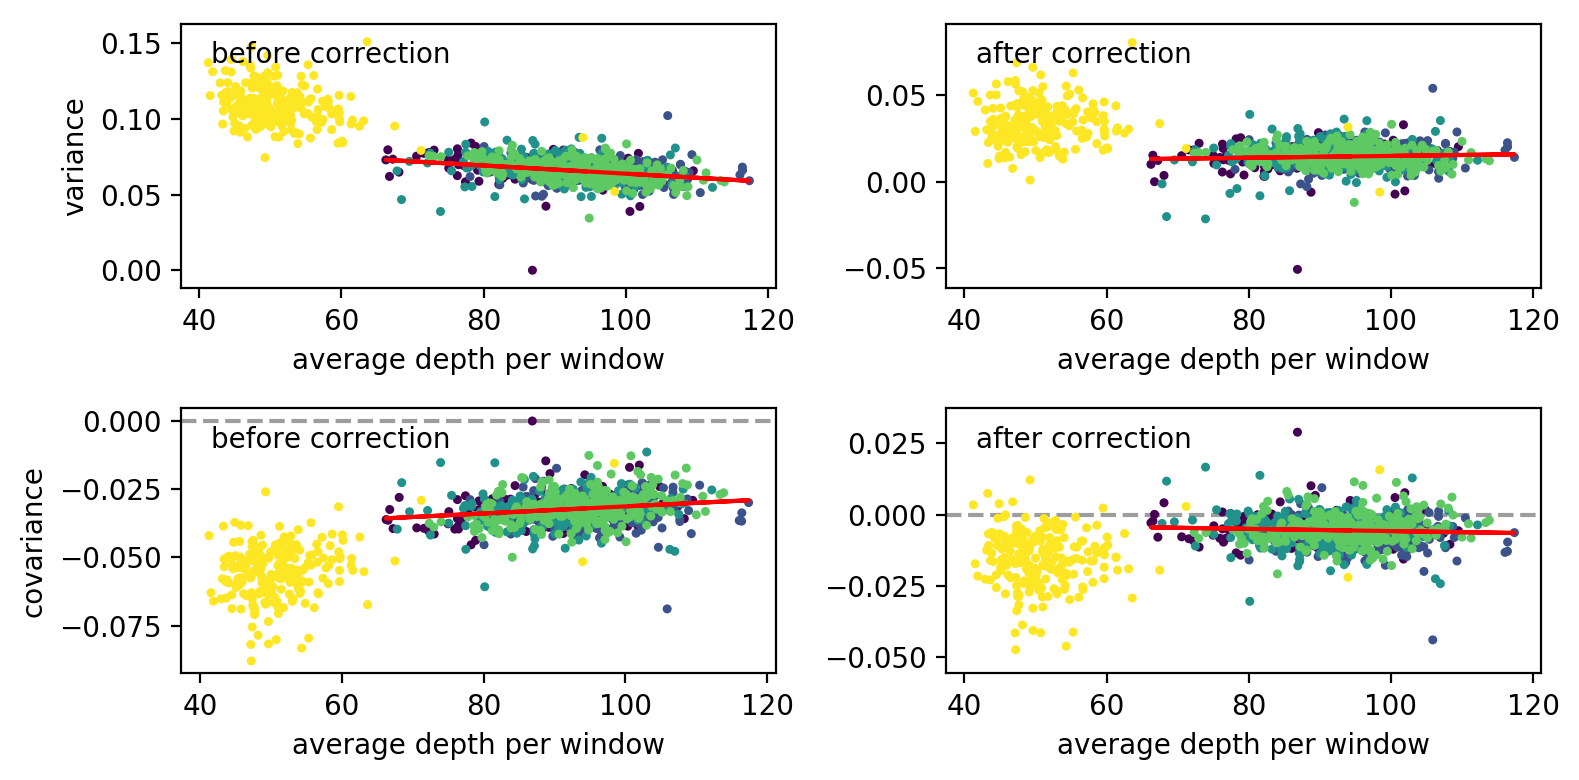

In [216]:
diagnostics = da.correction_diagnostics(exclude_seqids=['X'], use_masked=True, depth_limits=(40, 150), offdiag_k=1)
fig, ax = correction_diagnostic_plot(diagnostics)
# for i, j in product((0, 1), (0, 1)):
#     if i == 0:
#         ax[i, j].set_ylim(-0.04, 0.3)

In [193]:
megabase_tiles = GenomicIntervals.from_tiles(da.gintervals.seqlens, width=1e6)
da.set_tiles(megabase_tiles)
print("number of blocks: ", len(da.tile_indices))

number of blocks:  116


In [194]:
gw_temp_covs_cis = da.bootstrap_cov(B=5000, use_masked=True, progress_bar=True)

In [195]:
gw_temp_covs_cis

array([[[ 1.67240851e-02, -7.04814211e-03,  3.56470172e-04,
         -9.55481648e-04, -1.59306255e-04, -1.14957648e-03],
        [-7.04814211e-03,  2.95118641e-02, -1.66422500e-02,
         -6.85707502e-03,  9.77850541e-05, -2.53660011e-04],
        [ 3.56470172e-04, -1.66422500e-02,  1.56689265e-02,
         -3.59456635e-03, -1.90762699e-03,  3.18372070e-04],
        [-9.55481648e-04, -6.85707502e-03, -3.59456635e-03,
          1.89419989e-02, -6.65877841e-03, -7.12395223e-04],
        [-1.59306255e-04,  9.77850541e-05, -1.90762699e-03,
         -6.65877841e-03,  7.63439466e-03, -3.62654214e-03],
        [-1.14957648e-03, -2.53660011e-04,  3.18372070e-04,
         -7.12395223e-04, -3.62654214e-03,  3.27977560e-03]],

       [[ 1.79312552e-02, -6.41263186e-03,  8.69158562e-04,
         -3.81821629e-04,  3.43507604e-04, -6.41357321e-04],
        [-6.41263186e-03,  3.11021354e-02, -1.54651476e-02,
         -6.17740537e-03,  6.80021853e-04,  2.89150506e-04],
        [ 8.69158562e-04, -1.5

(-0.01, 0.01)

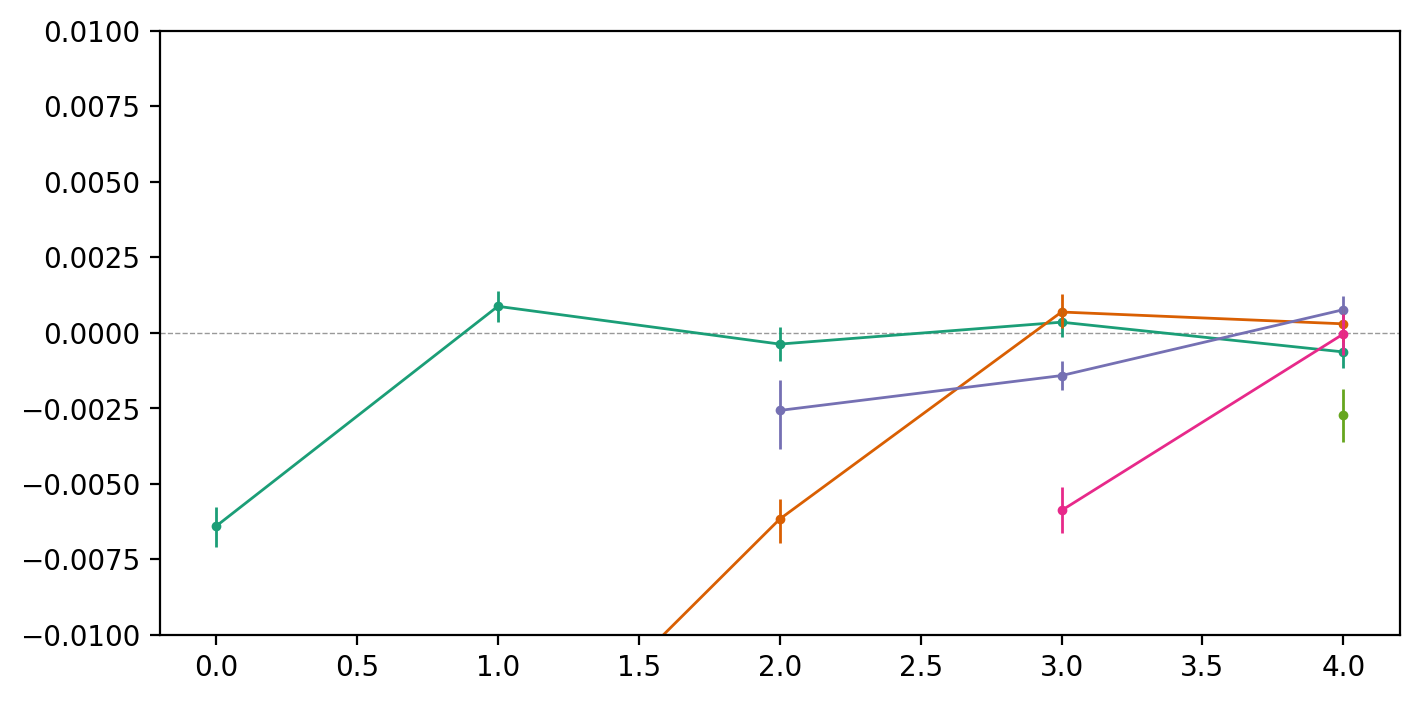

In [196]:
fig, ax = cov_plot(gw_temp_covs_cis)
ax.set_ylim(-0.01, 0.01)

In [200]:
ii = np.array([i for i, x in enumerate(sf.samples) if x.startswith('PA_7')])
de = [('pa', i) for i in range(3)]

da2 = TiledTemporalFreqs(tiles, 
                       freqs=sf.freqs[:, ii].T, 
                       depths=sf.N[:, ii].T,
                       diploids=diploids[ii],
                       samples=de, gintervals=gi)

In [201]:
da2.calc_cov(use_masked=True)

array([[ 0.03641944, -0.02130211],
       [-0.02130211,  0.03273094]])

In [202]:
plt.plot(timedeltas[np.arange(1, 6)], d2.cov[0,1:], 'o-', label=timedeltas[0])
plt.plot(timedeltas[np.arange(2, 6)], d2.cov[1,2:], 'o-', label=timedeltas[1])
plt.plot(timedeltas[np.arange(3, 6)], d2.cov[2,3:], 'o-', label=timedeltas[2])
plt.plot(timedeltas[np.arange(4, 6)], d2.cov[3,4:], 'o-', label=timedeltas[3])
plt.xlabel('generation')
plt.ylabel('covariance')
plt.axhline(0, c='99')
plt.legend()
plt.show()

NameError: name 'd2' is not defined